# Интеллектуальный анализ данных – весна 2024
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [1]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [2]:
df = pd.read_csv('/content/tweets_coronavirus.csv', encoding='latin-1')
df.head(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
1,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
2,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
3,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная эмоциональная окраска и 0 - если отрицательная.

In [3]:
data = df
data['Sentiment'] = ((df['Sentiment'] == "Extremely Positive") | (df['Sentiment'] == "Positive")).astype(int)
data.head(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,1
1,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,1
2,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,1
3,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",0


Сбалансированы ли классы?

In [4]:
from sklearn.utils.class_weight import compute_class_weight

# Получение весов классов
class_weights = compute_class_weight('balanced', classes=np.unique(data['Sentiment']), y=data['Sentiment'])

data['Sentiment'].value_counts()
class_weights

array([1.08598519, 0.92663194])

**Ответ:** Классы не сбалансированы, данные распределены неравномерно, т.к. первый класс является более частым (1.08598519), чем второй класс с частотой 0,92663194.

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [5]:
print("Пропущенные значения в наборе данных:", 'есть' if data.isna().any().any() else 'нет')

Пропущенные значения в наборе данных: есть


In [6]:
data = data.fillna("Unknown")
print("Пропущенные значения в наборе данных:", 'есть' if data.isna().any().any() else 'нет')

Пропущенные значения в наборе данных: нет


Разделите данные на обучающие и тестовые в соотношении 7 : 3 и `random_state=0`

In [7]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=0)

## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведение токенов в нижний регистр

In [8]:
import warnings

import nltk
from collections import Counter
import pandas as pd
from nltk.tokenize import word_tokenize

warnings.filterwarnings("ignore")

In [9]:
nltk.download("punkt", quiet=True)

tokens = word_tokenize(''.join([c.lower() for c in train['OriginalTweet']]))
vocabular = Counter(tokens)

Какой размер словаря получился?

In [10]:
len(vocabular.keys())

64888

Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе

In [11]:
vocabular.most_common(10)

[('#', 42753),
 ('the', 25939),
 ('to', 23316),
 ('.', 21753),
 (',', 17556),
 (':', 16478),
 ('and', 14736),
 ('of', 13007),
 ('https', 12850),
 ('a', 11516)]

**Ответ:** Эти токены в топе, потому что являются знаками пунктуации, артиклями, союзами и предлогами английского языка, которые чаще всего используются при письме. Самый популярный токен - решетка, т.к. зачастую пользователи твиттера используют различные хэштеги в каждом твитте более одного раза. 'https' означает частое указание ссылок пользователями.

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [12]:
from nltk.corpus import stopwords

nltk.download("stopwords", quiet=True)

stop_words = stopwords.words("english")
vocabular = Counter([token for token in tokens if token not in stop_words])

vocabular.most_common(10)

[('#', 42753),
 ('.', 21753),
 (',', 17556),
 (':', 16478),
 ('https', 12850),
 ('?', 11033),
 ('@', 9959),
 ('coronavirus', 8779),
 ('!', 4700),
 ('prices', 4483)]

**Ответ:**  После избавления от стоп-слов английского языка артикли, союзы и предлоги были удалены и, соответственно, теперь их нет в топе. Решетка для хэштега, знаки пункуации остались. Появились новые значения 'coronavirus' и 'prices', популярность первого обусловлена тем, что собранные твитты как раз таки о коронавирусе, а второго - цены стали популярной темой для обсуждения во время пандемии из-за экономических последствий карантина и ограничений, введённых для борьбы с распространением вируса.

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [13]:
[(key, value) for key, value in sorted(vocabular.items(), key = lambda item: item[1])[:20]]

[('//t.co/1m881cwfuv', 1),
 ('onlinewith', 1),
 ('//t.co/z0intks34xthe', 1),
 ('mnuchinã\x82â\x92s', 1),
 ('brink.finally', 1),
 ('//t.co/jmobv8z0u0friends', 1),
 ('catholicpres', 1),
 ('catholicuniv', 1),
 ('//t.co/evqby035wfit', 1),
 ('toiletpaperregulatory', 1),
 ('//t.co/riqrhxxeim', 1),
 ('ballardspahrll', 1),
 ('acaplease', 1),
 ('ã\x82â\x93necessaryã\x82â\x94', 1),
 ('quarantinelifequeues', 1),
 ('//t.co/0fmsmlgepmlt', 1),
 ('covid_19from', 1),
 ('irishman', 1),
 ('happystpatricksday', 1),
 ('guiness', 1)]

**Ответ:** Эти токены непопулярны, потому что они относятся к редко используемым словам и непопулярным ссылкам, причем часть из них имеет отдаленное отношение к пандемии.

Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [14]:
from nltk.tokenize import TweetTokenizer

tw = TweetTokenizer()
tokens = tw.tokenize(''.join([c.lower() for c in train['OriginalTweet']]))
vocabular = Counter(tokens)

vocabular.most_common(10)

[('the', 25991),
 ('to', 23329),
 ('.', 23269),
 (',', 17571),
 ('and', 14768),
 ('of', 13008),
 ('a', 11582),
 ('in', 11052),
 ('?', 9477),
 ('for', 8505)]

**Ответ:** Если сравнивать с самым первым результатом, то можно заметить, что TweetTokenizer поддерживает особенностей коротких сообщений твиттера, поэтому в топе нет значений, связанных с гиперссылками, смайликами и хештегами, остались только знаки пункуации и артикли/союзы/предлоги.

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [15]:
from string import punctuation

noise = stop_words + list(punctuation)
vocabular = Counter(token for token in tokens if token not in noise)

vocabular.most_common(10)

[('#coronavirus', 7643),
 ('â', 7214),
 ('\x82', 7113),
 ('19', 6549),
 ('covid', 5891),
 ('prices', 4470),
 ('\x92', 4252),
 ('food', 4222),
 ('store', 3846),
 ('supermarket', 3700)]

**Ответ:** В новом топе есть 3 значения, которые не похожи на слова, они являются какими-то  управляющими/специальными символами юникода.

Удалите из словаря токены из одного символа, с позицией в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [16]:
vocabular = Counter(token for token in tokens if (token not in noise) and not(len(token) == 1 and ord(token) >= 128))

print(f"Топ-10 самых популярных слов: {vocabular.most_common(10)}")
print(f"Топ-20 самых непопулярных слов: {[(key, value) for key, value in sorted(vocabular.items(), key = lambda item: item[1])[:20]]}")

Топ-10 самых популярных слов: [('#coronavirus', 7643), ('19', 6549), ('covid', 5891), ('prices', 4470), ('food', 4222), ('store', 3846), ('supermarket', 3700), ('grocery', 3414), ('people', 3324), ('#covid19', 2392)]
Топ-20 самых непопулярных слов: [('https://t.co/1m881cwfuv', 1), ('#onlinewith', 1), ('https://t.co/z0intks34xthe', 1), ('mnuchinã', 1), ('brink.finally', 1), ('https://t.co/jmobv8z0u0friends', 1), ("university's", 1), ('@catholicpres', 1), ('@catholicuniv', 1), ("https://t.co/evqby035wfit's", 1), ('#toiletpaperregulatory', 1), ('https://t.co/riqrhxxeim', 1), ('@ballardspahrll', 1), ('#acaplease', 1), ('#quarantinelifequeues', 1), ('https://t.co/0fmsmlgepmlt', 1), ('#covid_19from', 1), ('irishman', 1), ('#happystpatricksday', 1), ('guiness', 1)]


**Ответ:** Теперь полученные популярные токены являются значимыми словами, передающими наиболее обсуждаемыме темы во время пандемии (напр. можно понять, что людей волновали цены на продукты, работа супермаркетов и т.п.). Самые непопулярные токены представлены ссылками и редкими хэштегами, как и прежде. Так что можно сказать, что токены определяются теперь лчше.   

Выведите топ-10 популярных хештегов с количеством встреч. Что можно сказать о них?

In [17]:
[(key, value) for key, value in sorted(vocabular.items(), key = lambda item: -item[1]) if "#" in key][:10]

[('#coronavirus', 7643),
 ('#covid19', 2392),
 ('#covid_19', 1449),
 ('#covid2019', 763),
 ('#toiletpaper', 706),
 ('#covid', 621),
 ('#socialdistancing', 404),
 ('#coronacrisis', 336),
 ('#pandemic', 242),
 ('#coronaviruspandemic', 226)]

**Ответ:** Эти хештеги явно связаны с пандемией коронавируса, они отражают актуальные события и проблемы, связанные с распространением вируса и мерами по борьбе с ним.

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [18]:
[(key, value) for key, value in sorted(vocabular.items(), key = lambda item: -item[1]) if "https://t.co" in key][:10]

[('https://t.co/oxa7swtond', 5),
 ('https://t.co/deftrui1pfã\x82â', 3),
 ('https://t.co/wrlhyzizaa', 3),
 ('https://t.co/kuwipf1kqw', 3),
 ('https://t.co/zjnrx6dkkn', 3),
 ('https://t.co/catkegayoy', 3),
 ('https://t.co/g63rp042ho', 3),
 ('https://t.co/aziqcdgrnn', 3),
 ('https://t.co/bylqxrjmnt', 3),
 ('https://t.co/wuieefsnoj', 3)]

**Ответ:** Популярность ссылок заметно ниже по сравнению с хэштегами, вряд ли ссылка на конкретную страницу полезна, т.к. эмоциональная привязка к информации на нем разная.

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для изначального выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа, с позицией в таблице Unicode 128 и более и ссылки на t.co



In [19]:
def custom_tokenizer(text):
  lower_text = text.lower()
  noise = stopwords.words("english") + list(punctuation)
  tw = TweetTokenizer()
  tokens = tw.tokenize(lower_text)
  tokens = [t for t in tokens if (t not in noise) and not(len(t) == 1 and ord(t) >= 128) and not(t.startswith("https://t.co"))]
  return tokens

In [20]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=custom_tokenizer)
count_vector = cv.fit_transform(train['OriginalTweet'])
print(len(cv.vocabulary_))

45308


**Ответ:** Словарь из начала задания 2 был размером в 64888, полученный сейчас словарь меньше примерно на 30% благодаря удалению "шумов" - его текущий размер составляет 45308.

Посмотрим на какой-нибудь конкретный твитт:

In [22]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 0)

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [23]:
cv.fit(train['OriginalTweet'])
X = cv.transform([train.iloc[ind]['OriginalTweet']])
tokens = cv.get_feature_names_out()
cv_df = pd.DataFrame({'Name': tokens, 'CountTokens': X.toarray()[0]})

In [24]:
cv_df[cv_df['CountTokens'] == min(cv_df['CountTokens'][cv_df['CountTokens'] != 0])]

,Name,CountTokens
1833,#coronavirusoutbreak,1
2046,#covid2019,1
16658,@skynews,1
20553,brainless,1
26665,ffs,1
27042,food,1
27233,france,1
31579,lets,1
34079,nice,1
34688,one,1


In [25]:
cv_df[cv_df['CountTokens'] == max(cv_df['CountTokens'][cv_df['CountTokens'] != 0])]

,Name,CountTokens
1833,#coronavirusoutbreak,1
2046,#covid2019,1
16658,@skynews,1
20553,brainless,1
26665,ffs,1
27042,food,1
27233,france,1
31579,lets,1
34079,nice,1
34688,one,1


**Ответ:** Токены определились плохо, т.к. CountVectorizer просто подсчитывает количество раз, когда слово появляется в тексте.

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer(tokenizer=custom_tokenizer)
tfidf_vec.fit(train['OriginalTweet'])
X = tfidf_vec.transform([train.iloc[ind]['OriginalTweet']])

tokens = tfidf_vec.get_feature_names_out()

tfidf_df = pd.DataFrame({'Name': tokens, 'CountTokens': X.toarray()[0]})

In [27]:
tfidf_df[tfidf_df['CountTokens'] == min(tfidf_df['CountTokens'][tfidf_df['CountTokens'] != 0])]

,Name,CountTokens
27042,food,0.113289


In [28]:
tfidf_df[tfidf_df['CountTokens'] == max(tfidf_df['CountTokens'][tfidf_df['CountTokens'] != 0])]

,Name,CountTokens
20553,brainless,0.386764


**Ответ:** Токены определились хорошо, т.к. TfidfVectorizer  определяет не только значимость слова в тексте, но и значимость слова с учётом всех текстов.

Если слово часто встречается во всех документах (это в первую очередь касается предлогов, союзов и других стоп-слов), то вряд ли эти слова имеют большое значение. И наоборот, если слово встречаться только в одном документе, вероятно оно в большей степени определяет его содержание.

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [29]:
train[train['OriginalTweet'].apply(lambda x: 'thankful' in x) & (train['Sentiment'] == 1)]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
12899,19439,64391,"Los Angeles, CA",22-03-2020,"God Bless all first responders, Medical worker...",1
12781,19294,64246,"Hallandale Beach, FL",22-03-2020,"We should be thankful to our first responders,...",1
26998,36906,81858,"FL- Tampa, Orlando, Jax",07-04-2020,We are so truly thankful for our medical profe...,1
4337,9074,54026,"Manhattan, NY",18-03-2020,@ZachFlu A little anxious. Afraid I might've c...,1
1598,5743,50695,Unknown,17-03-2020,For years I have mocked my husband for the amo...,1
15948,23197,68149,"Denver, Colo.",24-03-2020,I'm thankful for our medical professionals and...,1
27985,38119,83071,"Provo, UT",08-04-2020,There are so many people to thank I m also tha...,1
29239,39679,84631,Unknown,09-04-2020,Very cool to see the Muddy River Distillery ma...,1
4250,8964,53916,"Florence,Italy",18-03-2020,Lockdown Day 9: I am grateful the grocery shop...,1
7977,13496,58448,"East Midlands, England",20-03-2020,I can t tell you how much admiration and respe...,1


In [30]:
ind = 12899
print(train.loc[ind]['OriginalTweet']) # положительно окрашенный твитт

X = tfidf_vec.transform([train.loc[ind]['OriginalTweet']])

tokens = tfidf_vec.get_feature_names_out()

tfidf_df = pd.DataFrame({'Name': tokens, 'CountTokens': X.toarray()[0]})

God Bless all first responders, Medical workers, Grocery store employees and Security personnel. These are some of the few people that have to work through these tough times. I for one, am extremely thankful! Stay safe everyone! #coronavirus #PrayingForAll


In [31]:
tfidf_df[tfidf_df['CountTokens'] == min(tfidf_df['CountTokens'][tfidf_df['CountTokens'] != 0])]

,Name,CountTokens
1740,#coronavirus,0.073151


In [32]:
tfidf_df[tfidf_df['CountTokens'] == max(tfidf_df['CountTokens'][tfidf_df['CountTokens'] != 0])]

,Name,CountTokens
6557,#prayingforall,0.382479


In [33]:
ind = 26998
print(train.loc[ind]['OriginalTweet']) # положительно окрашенный твитт

X = tfidf_vec.transform([train.loc[ind]['OriginalTweet']])

tokens = tfidf_vec.get_feature_names_out()

tfidf_df = pd.DataFrame({'Name': tokens, 'CountTokens': X.toarray()[0]})

We are so truly thankful for our medical professionals, first responders, grocery store employees, and all those who have stepped in front of this virus to help others #coronavirus #covid19 #thankyousomuch #firstresponders #beatcovid19 #quarantine #selfquarantine #flattenthecurve https://t.co/XwOE4BJYhX


In [34]:
tfidf_df[tfidf_df['CountTokens'] == min(tfidf_df['CountTokens'][tfidf_df['CountTokens'] != 0])]

,Name,CountTokens
1740,#coronavirus,0.06535


In [35]:
tfidf_df[tfidf_df['CountTokens'] == max(tfidf_df['CountTokens'][tfidf_df['CountTokens'] != 0])]

,Name,CountTokens
8460,#thankyousomuch,0.341689


**Ответ:** TfidfVectorizer выделил редкие хэштеги из-за их малой распространенности, в целом он хорошо определяет токены.

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [36]:
x_train = train.drop('Sentiment', axis=1)
y_train = train['Sentiment']

x_test = test.drop('Sentiment', axis=1)
y_test = test['Sentiment']

Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [38]:
vec = CountVectorizer(tokenizer = custom_tokenizer)
bow = vec.fit_transform(x_train['OriginalTweet'])  # bow — bag of words (мешок слов)
bow_test = vec.transform(x_test['OriginalTweet'])

In [39]:
clf = LogisticRegression()
clf.fit(X=bow, y=y_train)

pred_train = clf.predict(X=bow)
print(f"Доля правильных ответов на обучающих данных: {accuracy_score(y_train, pred_train)} (для CountVectorize)")

pred_test = clf.predict(X=bow_test)
print(f"Доля правильных ответов на тестовых данных: {accuracy_score(y_test, pred_test)} (для CountVectorize)")

Доля правильных ответов на обучающих данных: 0.9844510892780863 (для CountVectorize)
Доля правильных ответов на тестовых данных: 0.8674506677297189 (для CountVectorize)


In [40]:
vec = TfidfVectorizer(tokenizer = custom_tokenizer)
vec_train = vec.fit_transform(x_train['OriginalTweet'])
vec_test = vec.transform(x_test['OriginalTweet'])

clf = LogisticRegression()
clf.fit(X=vec_train, y=y_train)

pred_train = clf.predict(X=vec_train)
print(f"Доля правильных ответов на обучающих данных: {accuracy_score(y_train, pred_train)} (для TfidfVectorizer)")

pred_test = clf.predict(X=vec_test)
print(f"Доля правильных ответов на тестовых данных: {accuracy_score(y_test, pred_test)} (для TfidfVectorizer)")

Доля правильных ответов на обучающих данных: 0.9254592054677488 (для TfidfVectorizer)
Доля правильных ответов на тестовых данных: 0.8533984452860275 (для TfidfVectorizer)


**Ответ:** Векторайзер CountVectorize по сравнению с TfidfVectorizer показал лучшие результаты как на обучающих, так и на тестовых данных. Можно сказать, что модель лог регрессии дает хорошие результаты.

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [41]:
from nltk.stem.snowball import SnowballStemmer

def custom_stem_tokenizer(text):
  lower_text = text.lower()
  noise = stopwords.words("english") + list(punctuation)
  tw = TweetTokenizer()
  tokens = tw.tokenize(lower_text)
  tokens = [t for t in tokens if (t not in noise) and not(len(t) == 1 and ord(t) >= 128) and not(t.startswith("https://t.co"))]
  stemmer = SnowballStemmer("english")
  tokens = [stemmer.stem(w) for w in tokens]
  return tokens

In [42]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [43]:
cv_stem = CountVectorizer(tokenizer=custom_stem_tokenizer)
count_vector_cv_stem = cv_stem.fit_transform(train['OriginalTweet'])
print(len(cv_stem.vocabulary_))

36652


In [44]:
tfidf_stem = TfidfVectorizer(tokenizer=custom_stem_tokenizer)
tfidf_vector_stem = tfidf_stem.fit_transform(train['OriginalTweet'])
print(len(tfidf_stem.vocabulary_))

36652


**Ответ** Размер словаря стал меньше за счет удаления окончаний слов и приведения их к общей основе.

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [45]:
vec = CountVectorizer(tokenizer = custom_stem_tokenizer)
bow = vec.fit_transform(x_train['OriginalTweet'])
bow_test = vec.transform(x_test['OriginalTweet'])
clf = LogisticRegression()
clf.fit(X=bow, y=y_train)
pred_train = clf.predict(X=bow)
pred = clf.predict(X=bow_test)
print(f"Доля правильных ответов на обучающих и тестовых данных после стемминга: {accuracy_score(y_train, pred_train)}  и {accuracy_score(y_test, pred)} (для CountVectorize)")

vec = TfidfVectorizer(tokenizer = custom_stem_tokenizer)
vec_train = vec.fit_transform(x_train['OriginalTweet'])
vec_test = vec.transform(x_test['OriginalTweet'])
clf = LogisticRegression()
clf.fit(X=vec_train, y=y_train)
pred_train = clf.predict(X=vec_train)
pred = clf.predict(X=vec_test)
print(f"Доля правильных ответов на обучающих и тестовых данных после стемминга: {accuracy_score(y_train, pred_train)} и {accuracy_score(y_test, pred)} (для TfidfVectorizer)")

Доля правильных ответов на обучающих и тестовых данных после стемминга: 0.9717642033319095  и 0.8674506677297189 (для CountVectorize)
Доля правильных ответов на обучающих и тестовых данных после стемминга: 0.9158906450234943 и 0.8560892963922663 (для TfidfVectorizer)


**Ответ:** Качество немного улучшилось после применения стемминга, но осталось практически тем же, однако есть смысл применять стемминг - благодаря ему уменьшилось количество слов, что полезно для обработки.

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36651 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [46]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        max_df=7000
                        ).fit(
                            x_train['OriginalTweet']
                            )
print(len(cv_df.vocabulary_))

36651


**Ответ:** Параметр получился такой большой, потому что было необходимо уменьшить размер словаря на 1, для этого исключается слово, которое встречается более чем в 7000 твитах.

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [47]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df=11
                        ).fit(
                             x_train['OriginalTweet']
                            )
print(len(cv_df.vocabulary_))

3700


In [48]:
bow = cv_df.fit_transform(x_train['OriginalTweet'])
bow_test = cv_df.transform(x_test['OriginalTweet'])
clf = LogisticRegression()
clf.fit(X=bow, y=y_train)
pred_train = clf.predict(X=bow)
pred = clf.predict(X=bow_test)
print(f"Доля правильных ответов на обучающих и тестовых данных после стемминга: {accuracy_score(y_train, pred_train)}  и {accuracy_score(y_test, pred)} (для CountVectorize)")

Доля правильных ответов на обучающих и тестовых данных после стемминга: 0.9284493806065783  и 0.8677496511859677 (для CountVectorize)


**Ответ:** Токен должен появиться как минимум в 11 документах, чтобы быть учтенным, на результатах это сказывается лучшим образом, т.к. значимые токены все равно учитываются, а модель обучается легче на меньшем количестве данных.  

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `berplot` содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [49]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(bow.toarray())
x_test_scaled = scaler.transform(bow_test.toarray())

clf = LogisticRegression()
clf.fit(X=x_train_scaled, y=y_train)
pred_train_scaled = clf.predict(X=x_train_scaled)
pred_test_scaled = clf.predict(X=x_test_scaled)

print(f"Доля правильных ответов на обучающих и тестовых данных после скалирования: {accuracy_score(y_train, pred_train_scaled)} и {accuracy_score(y_test, pred_test_scaled)}")

Доля правильных ответов на обучающих и тестовых данных после скалирования: 0.9416915847928236 и 0.8446282639027307


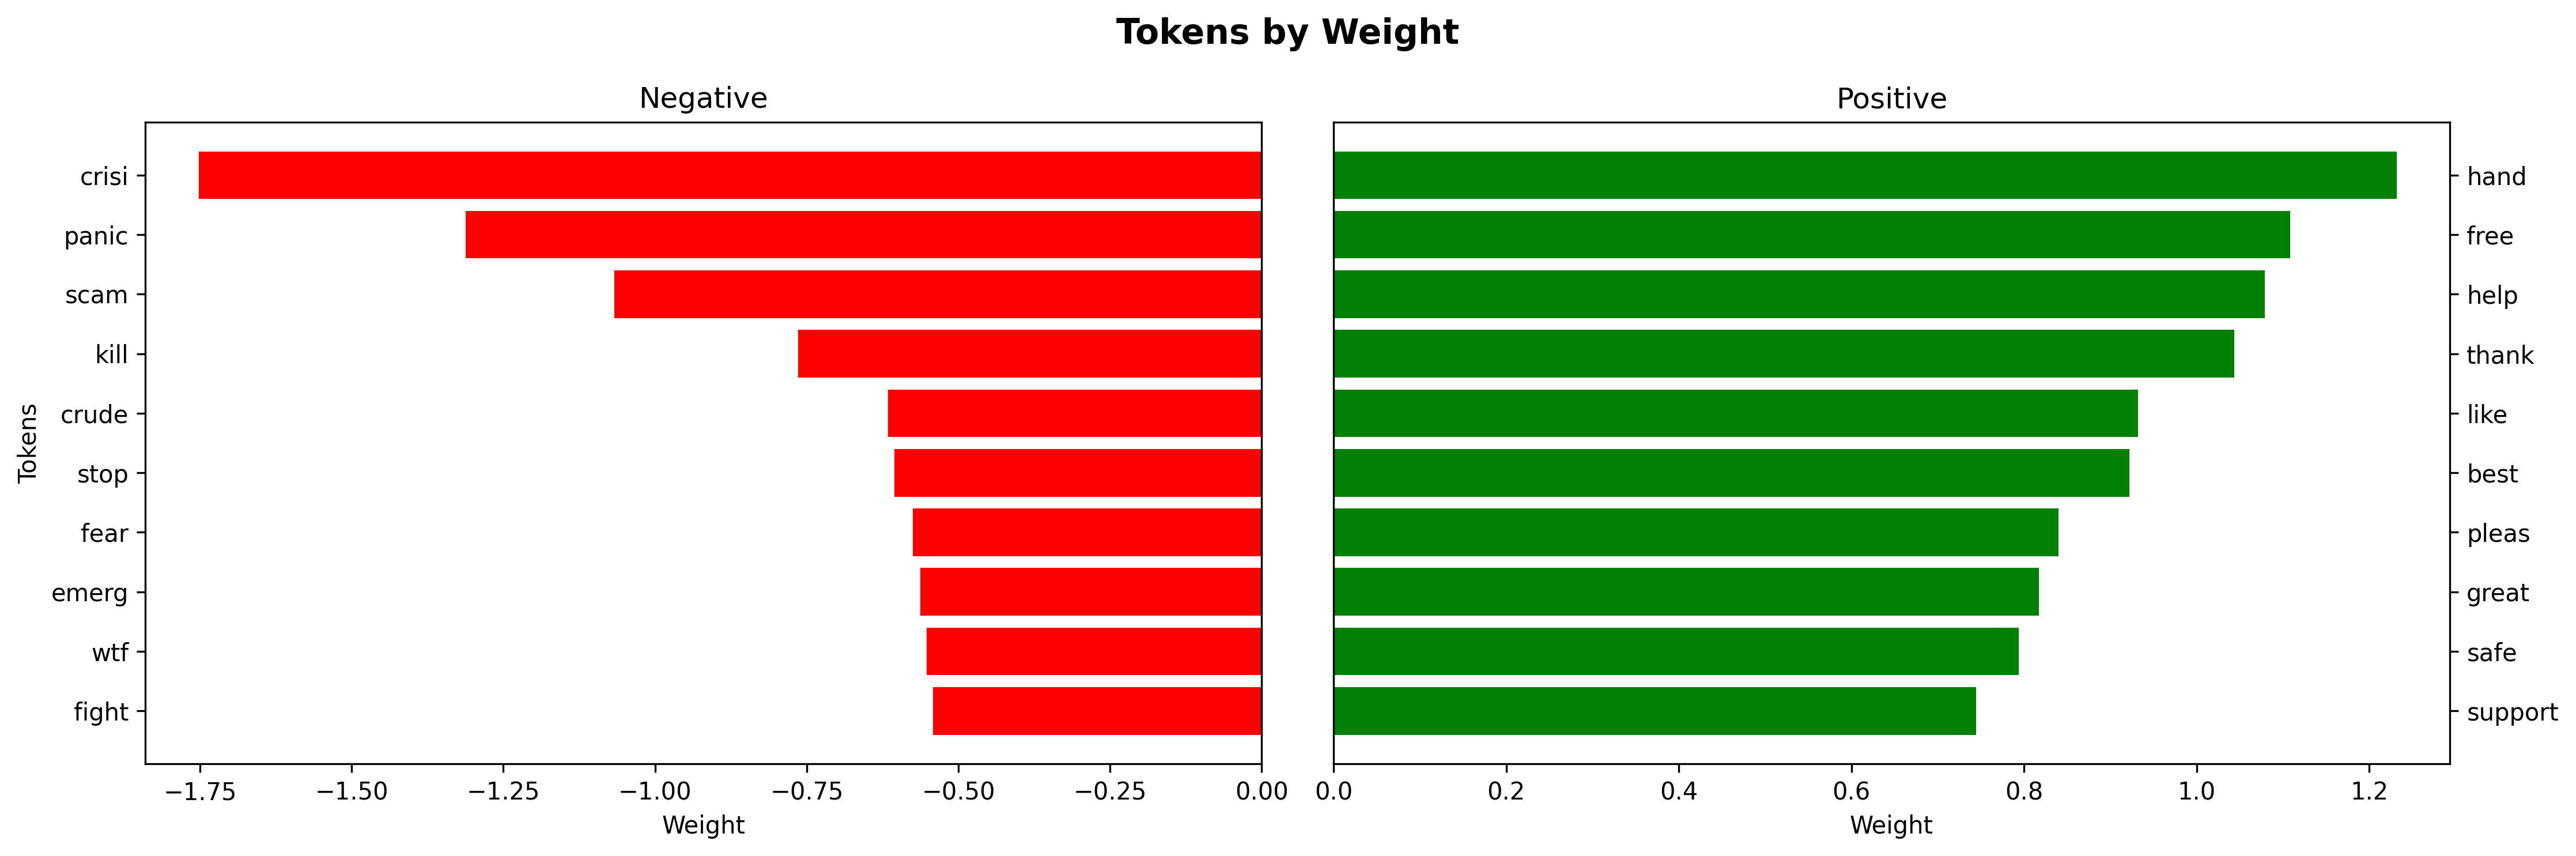

In [50]:
top_positive_indexes = np.argsort(clf.coef_[0])[-10:]
top_negative_indexes = np.argsort(-1 * clf.coef_[0])[-10:]

top_positive_tokens = [np.array(cv_df.get_feature_names_out())[idx] for idx in top_positive_indexes]
top_positive_weights = [clf.coef_[0][idx] for idx in top_positive_indexes]

top_negative_tokens = [np.array(cv_df.get_feature_names_out())[idx] for idx in top_negative_indexes]
top_negative_weights = [clf.coef_[0][idx] for idx in top_negative_indexes]

fig, ax = plt.subplots(1, 2, figsize=(15, 5), dpi=300, layout='tight')
fig.suptitle('Tokens by Weight', size='x-large', fontweight='bold')
ax[0].set_title('Negative')
ax[0].barh(top_negative_tokens, top_negative_weights,color='red')
ax[0].set_xlabel('Weight')
ax[0].set_ylabel('Tokens')

ax[1].set_title('Positive')
ax[1].barh(top_positive_tokens, top_positive_weights, color='green')
ax[1].yaxis.set_ticks_position('right')
ax[1].set_xlabel('Weight')

plt.subplots_adjust(left=0, right=1)
plt.show()

**Ответ:** Можно сказать, что токены определяются хорошо. В зависимости от веса токена определяется его положительная или отрицательная направленность.  

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [51]:
data.groupby(['UserName', 'ScreenName']).agg({'Sentiment': "sum"})

,,Sentiment
UserName,ScreenName,
3800,48752,1
3801,48753,1
3802,48754,1
3803,48755,0
3804,48756,1
...,...,...
44949,89901,1
44950,89902,1
44952,89904,0


In [52]:
len(data['UserName'].unique()), len(data['ScreenName'].unique())

(33444, 33444)

**Ответ:** Значений много и среди них нет выделяющихся, поэтому нет смысла использовать их для обучения модели.

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на оспнове целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

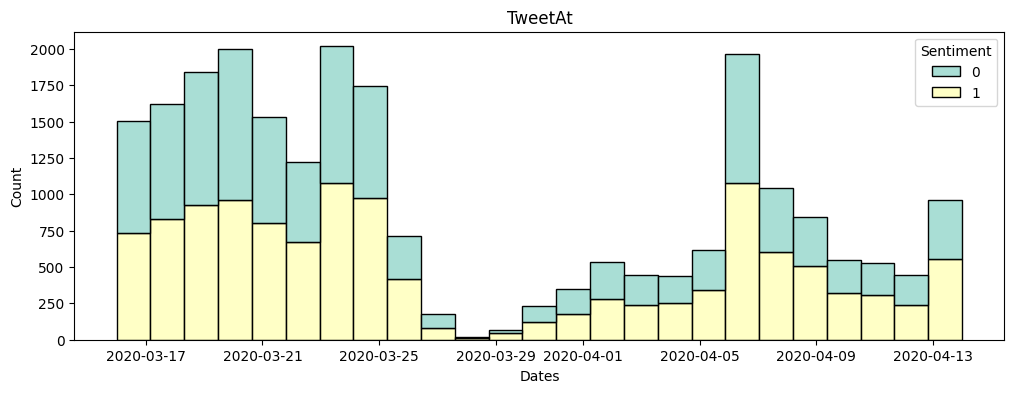

In [53]:
x_train['TweetAt'] = pd.to_datetime(x_train['TweetAt'], format="%d-%m-%Y")
plt.figure(figsize=(12, 4))
plt.title("TweetAt")
plt.xlabel("Dates")
plt.ylabel("Count")
sns.histplot(data=pd.concat([x_train['TweetAt'], y_train], axis=1), x='TweetAt', hue='Sentiment', multiple='stack', palette='Set3')
plt.show()

**Ответ:** На основе данных гистограммы можно заметить, что зависимости между целевой переменной и датой нет, т.е. дата не влияет на распределение положительных и отрицательных твиттов, первых всегда меньше практически в 2 раза. Поэтому данный признак не улучшит модель.



Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [54]:
print(f"Всего {len(x_train['Location'].unique())} уникальных значений: {x_train['Location'].unique()}")

Всего 7949 уникальных значений: ['Unknown' 'Boston, MA HQ' 'India' ... 'Skipton, England' 'lagos, NIGERIA'
 'Waterville, Ireland Austin, TX']


Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

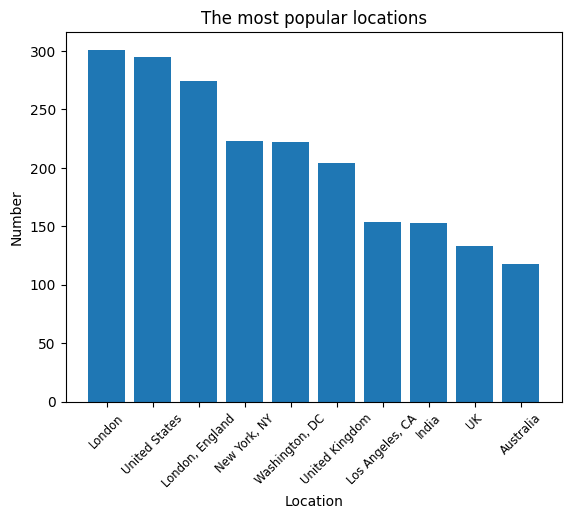

In [55]:
top_10 = x_train['Location'].value_counts()
top_10 = top_10[1:11]
plt.bar(top_10.index, top_10.values)
plt.xlabel("Location")
plt.xticks(rotation=45, fontsize='small')
plt.ylabel("Number")
plt.title("The most popular locations")
plt.show()

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

Теперь всего 4921 уникальных значений в train: ['Unknown' 'MA HQ' 'India' ... 'Whitehouse Bar & Pool Room' 'hyderabad'
 'NIGERIA']


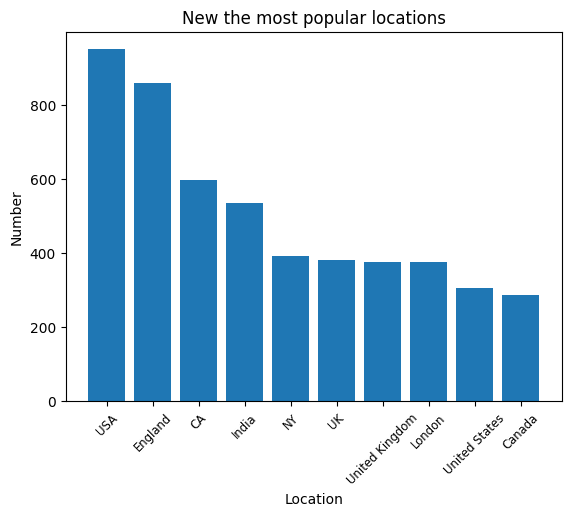

In [56]:
data['WiderLocation'] = data['Location'].apply(lambda x: x.split(', ')[-1])
x_train['WiderLocation'] = train['Location'].apply(lambda x: x.split(', ')[-1])

print(f"Теперь всего {len(x_train['WiderLocation'].unique())} уникальных значений в train: {x_train['WiderLocation'].unique()}")

top_10 = x_train['WiderLocation'].value_counts()
top_10 = top_10[1:11]
plt.bar(top_10.index, top_10.values)
plt.xlabel("Location")
plt.xticks(rotation=45, fontsize='small')
plt.ylabel("Number")
plt.title("New the most popular locations")
plt.show()

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [57]:
locations = data['WiderLocation'].value_counts()[data['WiderLocation'].value_counts() > 1].index
data['WiderLocation'] = data['WiderLocation'].apply(lambda x: x if x in locations else 'Unknown')
OHE_data = pd.get_dummies(data['WiderLocation'], prefix='WiderLocation')
OHE_train, OHE_test = train_test_split(OHE_data, test_size=0.3, random_state=0)
print(f"Всего {len(OHE_train.columns)} уникальных значений в train")

Всего 1354 уникальных значений в train


Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [63]:
from sklearn.preprocessing import OneHotEncoder

data['WiderLocation'] = data['WiderLocation'].astype('category')
encoder = OneHotEncoder(categories=[data['WiderLocation'].cat.categories], sparse=False)
ohe_feature = encoder.fit_transform(data[['WiderLocation']])
ohe_feature_train, ohe_feature_test = train_test_split(ohe_feature, test_size=0.3, random_state=27)
scaled_text_features_and_ohe_train = np.hstack((pd.DataFrame(scaler.fit_transform(OHE_train)), ohe_feature_train))
scaled_text_features_and_ohe_test = np.hstack((pd.DataFrame(scaler.transform(OHE_test)), ohe_feature_test))

clf = LogisticRegression()
clf.fit(scaled_text_features_and_ohe_train, y_train)

pred = clf.predict(scaled_text_features_and_ohe_test)

print(f"Доля правильных ответов: {accuracy_score(y_test, pred)}")

Доля правильных ответов: 0.5358780147498505


**Ответ:** Признак не оказался полезным, на результатах сказался не лучшим образом.

## Задание 8 Хорошее качество (Бонус 1 балл)

Добейтесь accuracy=0.88 на тестовой выборке (можно сменить токенайзер, векторайзер, модель и т.д.)